<a href="https://colab.research.google.com/github/atalianb/BeePy2.0/blob/main/MCMC_MH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Choose the "true" parameters.
m_true = 1.3
b_true = -3.1
f_true = 0.53

In [3]:
np.random.seed(123)

In [4]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

Text(0, 0.5, 'y')

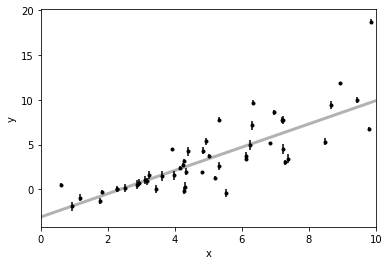

In [5]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

# **Mínimos cuadrados**






In [6]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))

In [7]:
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

Least-squares estimates:
m = 1.305 ± 0.016
b = -2.702 ± 0.091


Text(0, 0.5, 'y')

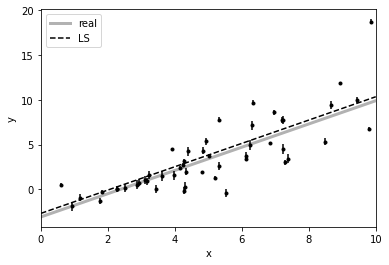

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="real")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(loc='upper left')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

# **Máximo likelihood**
$\ln{P(y|x,σ,m,b,f)} = -\frac{1}{2} ∑\left[ \frac{(y_{n}-mx_{n}-b)^{2}}{s^{2}_{n}}+\ln(2π s^{2}_n) \right]$


donde
$s^{2}_{n} = \sigma^{2}_{n} + f^{2}(mx_{n
}+b)^{2}$

Podemos notar que el likelihood es una Gaussiana donde la varianza está estimada por una fracción $f$

In [9]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [10]:
from scipy.optimize import minimize

In [11]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

In [12]:
soln

      fun: 46.76590681995795
 hess_inv: array([[ 0.01259143, -0.03336343, -0.0093778 ],
       [-0.03336343,  0.10210922,  0.02124599],
       [-0.0093778 ,  0.02124599,  0.02011692]])
      jac: array([-2.86102295e-06, -1.43051147e-06,  4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([ 1.23022129, -2.83365144, -0.58342887])

In [13]:
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
m = 1.230
b = -2.834
f = 0.558


Text(0, 0.5, 'y')

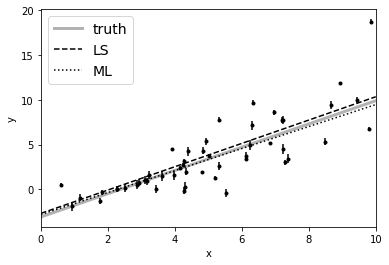

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

# ¿Cómo calculamos las incertidumbres de los parámetros?

In [15]:
def lnlike(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2)
    return -0.5*(np.sum((y-model)**2 - np.log(inv_sigma2)))

In [16]:
plist = [0.0,5.0,-5.0,0.0]

In [17]:
def lnprior(theta, plist):
    m, b = theta
    if plist[0] < m < plist[1] and plist[2] < b < plist[3]:
        return 0.0
    return -np.inf

In [18]:
sigma_m = 0.1#tamaño del paso
sigma_b = 0.3#
paso_i = [1.3,-3.1]#Iniciar con otro conjunto de parametros
NS = 1000#Numero de pasos

In [19]:
cadena = [paso_i]
pcadena = []

In [20]:
def mc(pasos, sigma_m,sigma_b, paso_inicial):
    cadena = [paso_inicial]
    pcadena = []
    theta_old = [m_true,b_true]
    for i in range(NS):
        m_new = np.random.normal(m_true,sigma_m)
        b_new = np.random.normal(b_true,sigma_b)
        theta_new = [m_new, b_new]
        p_new = lnlike(theta_new, x, y, yerr)
        p_old = lnlike(theta_old,x, y,yerr)
        #p = lnprior(m_new,b_new)
        p_n = np.exp(p_new - p_old)
        p_n = min(1., p_n)
        if (p_new/p_old>1):
            theta_old = theta_new
        else:
            r = np.random.uniform(0.,1.)
            if (p_n >= r):
                theta_old = theta_new
                cadena.append(theta_new)
                pcadena.append(p_new)
            else:
                cadena.append(theta_old)
                pcadena.append(p_old)
    cadena = np.array(cadena)
    pcadena = np.array(pcadena)
    return cadena, pcadena

In [21]:
cad,pcad = mc(NS, sigma_m,sigma_b, paso_i)

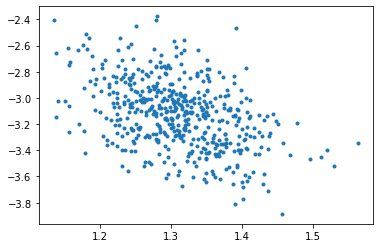

In [22]:
plt.scatter(cad[:,0],cad[:,1],s=None, marker='.')

Text(0.5, 0, 'pasos')

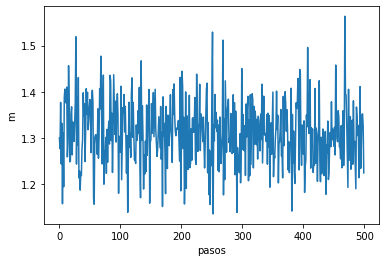

In [23]:
plt.plot(cad[:,0])
plt.ylabel('m')
plt.xlabel('pasos')

Text(0.5, 0, 'pasos')

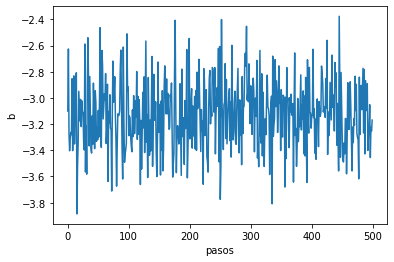

In [24]:
plt.plot(cad[:,1])
plt.ylabel('b')
plt.xlabel('pasos')

(array([ 15.,  30.,  85., 116., 112.,  79.,  46.,  12.,   3.,   2.]),
 array([1.13546013, 1.17825633, 1.22105254, 1.26384875, 1.30664496,
        1.34944116, 1.39223737, 1.43503358, 1.47782979, 1.520626  ,
        1.5634222 ]),
 <a list of 10 Patch objects>)

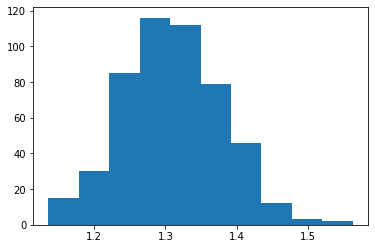

In [25]:
plt.hist(cad[:,0])

(array([  3.,  17.,  33.,  91., 100., 120.,  71.,  41.,  18.,   6.]),
 array([-3.88592353, -3.73495272, -3.5839819 , -3.43301108, -3.28204027,
        -3.13106945, -2.98009864, -2.82912782, -2.67815701, -2.52718619,
        -2.37621537]),
 <a list of 10 Patch objects>)

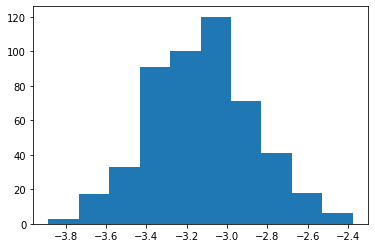

In [26]:
plt.hist(cad[:,1])

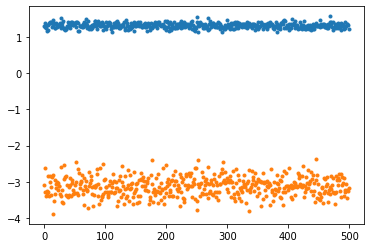

In [27]:
plt.plot(cad, '.')

In [28]:
! python -m pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import corner

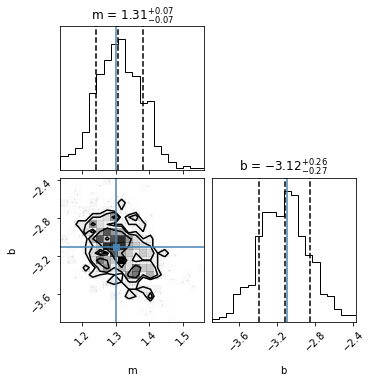

In [30]:
corner.corner(cad, labels=['m','b'],truths=[m_true, b_true], quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12});

In [31]:
m_mcmc = 1.31
b_mcmc = -3.15

Text(0, 0.5, 'y')

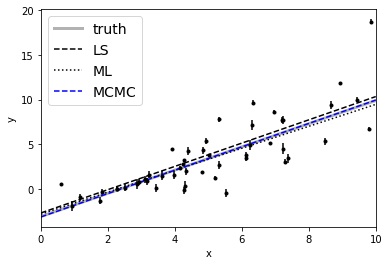

In [32]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.plot(x0,m_mcmc*x0+b_mcmc,'--b', label='MCMC')
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

## Usando emcee

In [33]:
! pip install -U emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import emcee
from scipy import optimize

In [35]:
nll = lambda *args: -lnlike(*args)
result = optimize.minimize(nll, [m_true, b_true], args=(x, y, yerr))
print(result)
m_ml, b_ml = result.x

      fun: 179.16763452115177
 hess_inv: array([[ 0.00351116, -0.01722441],
       [-0.01722441,  0.10440008]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([ 1.33613964, -3.2534618 ])


In [36]:
def posti(theta, x, y, yerr):
    lp = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [37]:
ndim = 2#numero de parametros libres
nwalkers = 10#numero de caminantes

In [38]:
post = [result.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [39]:
post

[array([ 1.33630979, -3.25357262]),
 array([ 1.33597352, -3.25354465]),
 array([ 1.33607336, -3.25363654]),
 array([ 1.33612684, -3.25336695]),
 array([ 1.33601104, -3.25345304]),
 array([ 1.33617923, -3.25347013]),
 array([ 1.33615821, -3.25344206]),
 array([ 1.33605837, -3.25331194]),
 array([ 1.33626442, -3.2533428 ]),
 array([ 1.33624101, -3.25361929])]

In [40]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, posti, args=(x, y, yerr))

In [41]:
sampler.run_mcmc(post,1000)#1000pasos

State([[ 1.3278463  -3.28109111]
 [ 1.33808043 -3.23633935]
 [ 1.34018271 -3.39900974]
 [ 1.34672224 -3.27886345]
 [ 1.37894687 -3.40988853]
 [ 1.32492163 -3.09954666]
 [ 1.27192164 -2.98955387]
 [ 1.29088476 -3.2050451 ]
 [ 1.2874722  -3.05110541]
 [ 1.36543721 -3.48184309]], log_prob=[-358.58372163 -358.37182423 -359.08501989 -358.40127154 -358.98631565
 -358.92152609 -359.66607954 -360.39071737 -359.085422   -358.87300667], blobs=None, random_state=('MT19937', array([2311309880, 3510651751,  396664900,  238283800, 3330884088,
       1116795701, 1074835631, 2464222269, 1997390318, 3193014819,
       1432215085, 2746544961, 3645844068, 3879801855, 2208361623,
       3403010447, 3181505745, 1747798930, 3386503728,  255773721,
       2081222611,  792652316, 3740298981,  596034826,  410271258,
       4004640467,  616986490, 3292933586, 3458969629, 2357773892,
        406945186, 2210570154, 4236487822, 3359329869,  699331398,
        320437453, 3951944208, 2053344060, 1564121444, 24858441

In [42]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))#50:Burning

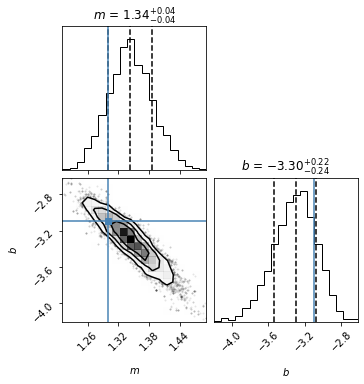

In [43]:
fig = corner.corner(samples, labels=["$m$", "$b$"],truths=[m_true, b_true],
                     quantiles=[0.16, 0.5, 0.84],
    show_titles=True,title_kwargs={"fontsize": 12})